# Imports

In [ ]:
import os
import math
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    EarlyStopping,
    ReduceLROnPlateau,
    ModelCheckpoint
)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import keras_tuner as kt

# Data

In [2]:
labels_df = pd.read_csv(r"D:\\Cancer_Detection\train_labels.csv")
train_dir = r"D:\Cancer_Detection\train"
test_dir = r"D:\Cancer_Detection\test"

The  purpose of this project is to develop initial results for a deep learning model to detect cancer in histopathologic images. The model will classify lymph node sections as either containing cancer or not (positive/ negative). 
The source of the data is Kaggle, here is a direct link
https://www.kaggle.com/competitions/histopathologic-cancer-detection/data

The Dataset features 220,025 images in the training set which will be split into 176,020 for training and 44,005 images for validation. The test set features 57,458 images which will be used to score the model. 
The distribution of classes is 130,908 images without cancer and 89,117 images with cancer. 

# Data Transforms

- There is no data cleaning that needs to be done as there are no missing data files in regards to missing ID numbers or photos without labels. 

- The only data prep that needs to be done is to add .tif to the labeled data so that it matches the photo ID.

- I will be doing minor data augmentation through the use of Keras ImageDataGenerator. Utilizing this library I will apply
    - Rescale images
        - This normalizes pixel values of images
    - Rotation
        - This introduces variability which helps the model recognize objects regardless of orientation
    - Width and Height shifting 
        - This simulates translations, so the model can recognize objects even if they aren't centered 
    - Sheer transformation
        - This introduces tilt that simulates different perspectives, helping the model to view cancer from different perspectives
    - Zoom
        - This helps the model handle variations in scale which might be needed depending on the tumor size

In [ ]:
# Add image extension to labeled data to match photo ID's 1 to 1
labels_df['id'] = labels_df['id'] + '.tif'

In [ ]:
# Check for image file mismatch 
missing_files = []
for img_id in labels_df['id']:
    img_path = os.path.join(train_dir, img_id)
    if not os.path.exists(img_path):
        missing_files.append(img_id)

print(f'Number of missing files: {len(missing_files)}')


Number of missing files: 0


In [5]:
# Create Validation set to test model on unseen data (that has a label)
train_df, val_df = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=42
)

In [6]:
# Change labels from "int" to "str"
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)

In [7]:
# Data generators for memory effeciency 
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

# Validation generator
validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


# Data Description

In [ ]:
# Overall info
print(labels_df.info())

# Class distribution
print(labels_df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
label
0    130908
1     89117
Name: count, dtype: int64


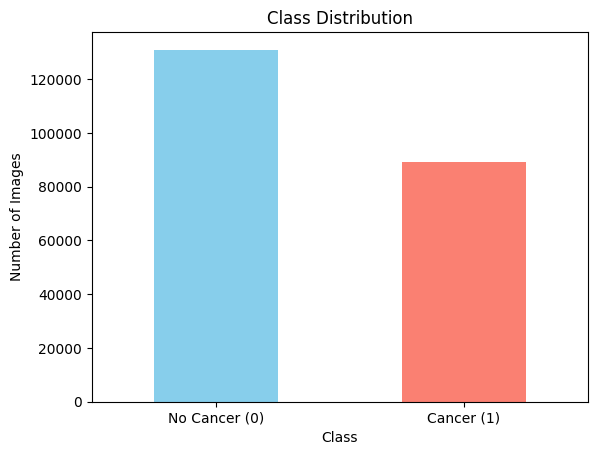

In [ ]:
# Class distribution histogram
labels_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.show()

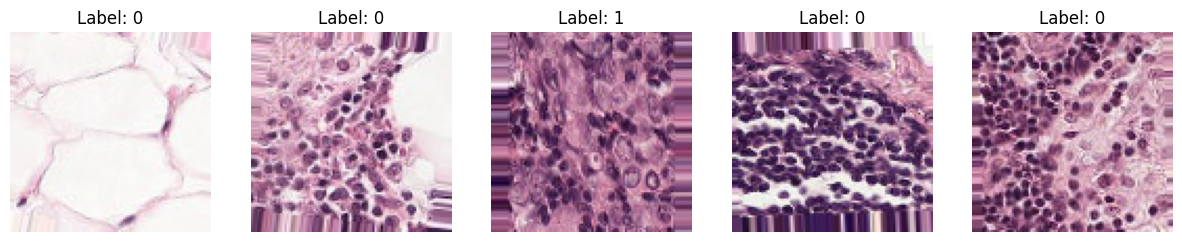

In [ ]:
# Function to display images with labels
def show_images(generator, num_images):
    x_batch, y_batch = next(generator)
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img = x_batch[i]
        label = y_batch[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {int(float(label))}')
        plt.axis('off')
    plt.show()

# Show example photos pre augment 
show_images(train_generator, 5)


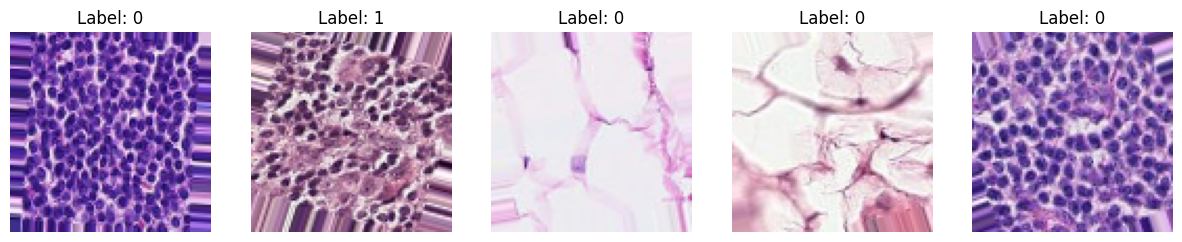

In [ ]:
# Show example photos post augment 
show_images(train_generator, 5)

Based on my EDA I will utilize a general CNN architecture as a framework and then adapt it to our task via hyperparameter tuning. 

# Model Architecture 

Architecture layout based on final model:
- Some of these values were tweaked in the tuning process like filter number in each conv2D layer, kernal sizes and rates
- This general structure remains unchanged during testing 

1)	Input Layer 
    - Input shape (96,96,3) 
    - The model should only accept 96x96 pixel images in RGB format. 

2)	Convolutional Block 1
    - Conv2D Layer
        - Filters = 64
        - Kernal size = (3,3)
        - Activation = ReLU
    - MaxPooling 2D layer
        - Pool Size = (2,2)
    - BatchNormalization Layer
        - Normalizes output

3)	Convolutional Block 2
    - Conv2D Layer
        - Filters = 192
        - Kernal size = (3,3)
        - ctivation = ReLU
    - MaxPooling 2D layer
         - Pool Size = (2,2)
    - BatchNormalization Layer
        - Normalizes output

4)	Convolutional Block 3
    - Conv2D Layer
        - Filters = 128
        - Kernal size = (5,5)
        - Activation = ReLU
    - MaxPooling 2D layer
        - Pool Size = (2,2)
    - BatchNormalization Layer
        - Normalizes output

5)	Flatten Layer
    - 2D feature maps -> 1D feature vector 

6)	Fully Connected Layers
    - Dense Layer
        - Units = 128
        - Activation = ReLU
    - Dropout Layer
        - Rate = 0.6
        - Curb overfitting
    - Batch Normalization Layer
        - Normalizes output

7)	Output Layer
    - Dense Layer
        - Units = 1
        - Activation = Sigmoid
        - Give Result as 0 or 1


Convolutional Layers
The purpose behind the convolutional layers is to extract special features by applying filters. As the model increases layers the number of filters increases with the idea that each layer will capture more complex patterns. The ReLU activation function introduces non-linearity which should allow the model to learn relationships that are non-linear. 

MaxPooling Layers
The purpose of the MaxPooling layers is to reduce the spatial dimension of the feature maps. This should decrease the cost of computation. 

Batch Normalization 
The Batch Normalization layers normalizes the previous layer such that the previous layer would have a mean of zero and a standard deviation of one. This should lead to higher learning rates. 

Flatten Layer
The Flatten Layer transforms the 2D feature maps into 1D so that dense layers can be used

Fully Connected Layers
In the fully connected layers, I used a 128 unit dense layer which tries to learn high level features. A dropout layer is also present in an attempt to curb overfitting

Output Layer
This layer outputs a probability between 0 and 1, which for my model > 50% would be positive. In the real world personally I would rather have a model that would air on the side of caution. 


# CNN Model Building

In [ ]:
def build_model(hp):
    model = Sequential()
    
    # First Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),  
        kernel_size=hp.Choice('conv_1_kernel_size', values=[3, 5]),               
        activation='relu',
        input_shape=(96,96,3)
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    # Second Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice('conv_2_kernel_size', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    # Third Convolutional Layer
    model.add(Conv2D(
        filters=hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        kernel_size=hp.Choice('conv_3_kernel_size', values=[3, 5]),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    
    model.add(Flatten())
    
    # Dense Layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1)))
    model.add(BatchNormalization())
    
    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    
    # Compile 
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [ ]:
# Random search hyperparameter tuning initialization 
tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective='val_accuracy', # Goal
    max_trials=10,  # Total number of different models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparam_tuning',
    project_name='cancer_detection'
)

Reloading Tuner from hyperparam_tuning\cancer_detection\tuner0.json


In [ ]:
# Function to extract data from generators
def generator_to_data(generator, steps):
    x_list, y_list = [], []
    for _ in range(steps):
        x_batch, y_batch = next(generator)
        x_list.extend(x_batch)
        y_list.extend(y_batch)
    return np.array(x_list), np.array(y_list)

# Reset generators
train_generator.reset()
validation_generator.reset()

# Calculate steps
train_steps = train_generator.samples // train_generator.batch_size
val_steps = validation_generator.samples // validation_generator.batch_size

# Extract data
x_train, y_train = generator_to_data(train_generator, steps=500)  
x_val, y_val = generator_to_data(validation_generator, steps=100)

In [ ]:
# Early Stopping callback
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Start Search
tuner.search(
    x_train, y_train,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[earlystop]
)

In [33]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Early stopping to prevent overfitting
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-7, verbose=1)

# Save the best model
checkpoint = ModelCheckpoint('best_model_tuned.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Define the callbacks list
callbacks = [earlystop, reduce_lr, checkpoint]

In [ ]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Recompile 
model.compile(
    optimizer=Adam(learning_rate=best_hps.get('learning_rate')),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Train the model on full dataset
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,
    callbacks=callbacks  
)

Epoch 1/25


c:\Users\blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\blake\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.7993 - loss: 0.4599
Epoch 1: val_loss improved from inf to 0.47099, saving model to best_model_tuned.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 923s 168ms/step - accuracy: 0.7993 - loss: 0.4599 - val_accuracy: 0.8165 - val_loss: 0.4710 - learning_rate: 2.0777e-04
Epoch 2/25
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 13:18 145ms/step - accuracy: 0.9688 - loss: 0.1721
Epoch 2: val_loss improved from 0.47099 to 0.13556, saving model to best_model_tuned.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.9688 - loss: 0.1721 - val_accuracy: 1.0000 - val_loss: 0.1356 - learning_rate: 2.0777e-04
Epoch 3/25


c:\Users\blake\AppData\Local\Programs\Python\Python312\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8738 - loss: 0.3076
Epoch 3: val_loss did not improve from 0.13556
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 924s 168ms/step - accuracy: 0.8738 - loss: 0.3076 - val_accuracy: 0.8107 - val_loss: 0.6393 - learning_rate: 2.0777e-04
Epoch 4/25
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 13:50 151ms/step - accuracy: 0.8750 - loss: 0.2965
Epoch 4: val_loss improved from 0.13556 to 0.11162, saving model to best_model_tuned.keras
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 18us/step - accuracy: 0.8750 - loss: 0.2965 - val_accuracy: 1.0000 - val_loss: 0.1116 - learning_rate: 2.0777e-04
Epoch 5/25
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.8992 - loss: 0.2564
Epoch 5: val_loss did not improve from 0.11162
5500/5500 ━━━━━━━━━━━━━━━━━━━━ 928s 169ms/step - accuracy: 0.8992 - loss: 0.2564 - val_accuracy: 0.7922 - val_loss: 0.5720 - learning_rate: 2.0777e-04
Epoch 6/25
   1/5500 ━━━━━━━━━━━━━━━━━━━━ 14:22 157ms/step - accuracy: 0.9688 - loss: 0.0947
Epoch 6: v

- Hyperparameters Tuning Summary

- For hyperameter tuning my model looped through a range of different hyperameter settings to optimize validation set accuracy. 
That is a portion of the training data that I had labels for but was unseen by my model thereby mimicking a testing set submission. 
While I did experiment with changes to model structure due the requirements being to not excessively optimize I did optimize parameters at each neural network level. 

    - The number of filters in convolution layers was optimized for each layers one, two and three. 
        - First Layer tested values = [32,64,96,128]
        - Second layer tested values = [64,128,192,256]
        - Third layer tested values = [128,256,384,512]
    - The Size of the Kernal 
        - First Layer tested values = [3,5]
        - Second layer tested values = [3,5]
        - Third layer tested values = [3,5]
    - The dense layer units 
        - Density layer tested values = [64,128, 192, 256]
    - The dense layer Dropout rate
        - Dropout rate values tested = [0.3,0.4,0.5,0.6,0.7]
    - The learning rate
        - The learning rate values tested were [1e-5 to 1e-3] with a logrithmic step 


# Results

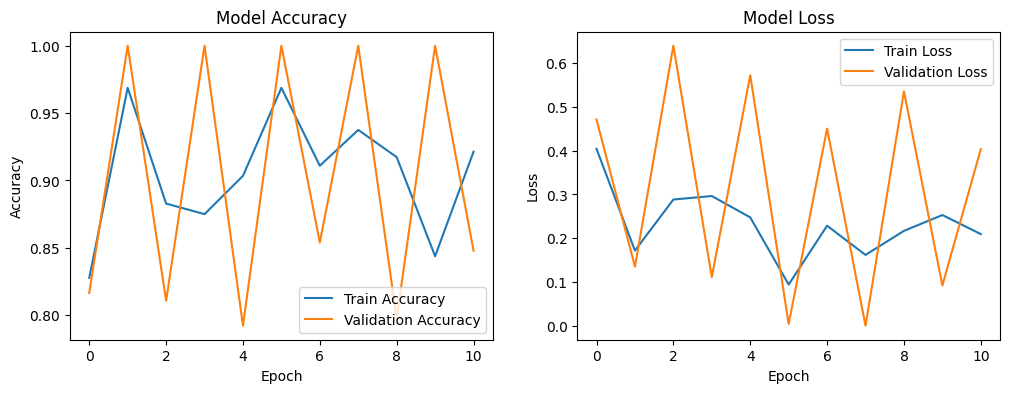

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 47, 47, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 47, 47, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 45, 45, 192)    │       110,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 22, 22, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 22, 192)    │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 18, 18, 128)    │       614,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,327,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,167,493 (23.53 MB)

 Trainable params: 2,055,489 (7.84 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 4,110,980 (15.68 MB)

In [ ]:
# Model Performance 
val_loss, val_accuracy = model.evaluate(
    validation_generator,
    steps=validation_generator.samples // validation_generator.batch_size
)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 67s 49ms/step - accuracy: 0.8511 - loss: 0.4650
Validation Loss: 0.4641
Validation Accuracy: 0.8522


In [ ]:
# Get true labels and predictions
validation_generator.reset()
val_labels = validation_generator.classes
val_preds = (model.predict(validation_generator) > 0.5).astype("int32").flatten()

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
print('Confusion Matrix')
print(cm)

# Classification report
print('Classification Report')
print(classification_report(val_labels, val_preds, target_names=['No Cancer', 'Cancer']))


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 64s 47ms/step
Confusion Matrix
[[25744   438]
 [ 6065 11758]]
Classification Report
              precision    recall  f1-score   support

   No Cancer       0.81      0.98      0.89     26182
      Cancer       0.96      0.66      0.78     17823

    accuracy                           0.85     44005
   macro avg       0.89      0.82      0.84     44005
weighted avg       0.87      0.85      0.85     44005



- My final values for each hyperarameters 
    - conv_1_filters: 64
    - conv_1_kernel_size: 3
    - conv_2_filters: 192
    - conv_2_kernel_size: 3
    - conv_3_filters: 128
    - conv_3_kernel_size: 5
    - dense_units: 128
    - dropout_rate: 0.6
    - learning_rate: 2.07e-4



These values were found using random search. There was a total of 10 trials and each configuration was tested once. The ideal combination was chosen based on validation accuracy. 
The validation accuracy jumped around a bit and had periods at 100% during training but the final accuracy on validation was about 85% with a validation loss of .0047 in the best performing epoch. Due to the high training accuracy at times, I utilized a high dropout rate of 0.6 to prevent overfitting. The learning rate was optimized to get stable convergence without overshooting. 
The number of filters enhanced my model’s ability to find complex features. This was paired with a smaller kernel size to find fine grained patterns. As the layers deepened the kernel size increased to capture more abstract features within the fine-grained pattern that passed through initial filtering. 
The dense layer unit number needed to be sufficient to interpret flattened feature maps while balancing complexity. 


# Kaggle Submission 

In [ ]:
# Create a DataFrame with test image filenames
test_filenames = os.listdir(test_dir)
test_df = pd.DataFrame({
    'filename': test_filenames
})

# Initialize ImageDataGenerator with rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Create test generator 
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,                
    target_size=(96, 96),
    color_mode='rgb',
    class_mode=None,           
    batch_size=32,
    shuffle=False              
)

# Define a generator wrapper
def generator_wrapper(gen):
    while True:
        batch = next(gen)
        yield (batch,)  # Wrap the batch in a tuple

# Instantiate the wrapped generator
wrapped_test_generator = generator_wrapper(test_generator)

# Calculate the number of steps
steps = math.ceil(test_generator.samples / test_generator.batch_size)

# Make predictions using the wrapped generator
predictions = model.predict(wrapped_test_generator, steps=steps, verbose=1)

# Convert probabilities to binary class labels (0 or 1) using a threshold of 0.5
predicted_classes = (predictions > 0.5).astype(int).flatten()

# Verify predictions
print(f"Number of test images: {test_generator.samples}")
print(f"Number of predictions: {len(predicted_classes)}")

# Prepare submission DataFrame
filenames = test_generator.filenames
submission_df = pd.DataFrame({
    'id': filenames,
    'label': predicted_classes
})

# Save to CSV to submit to Kaggle
submission_df.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!")

Found 57458 validated image filenames.
1796/1796 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step
Number of test images: 57458
Number of predictions: 57458
Submission file 'submission.csv' created successfully!


In [35]:
# Edit CSV output to remove .tif

# The submission file
submission = pd.read_csv(r"D:\\Cancer_Detection\submission.csv")

# Remove the .tif
submission['id'] = submission['id'].apply(lambda x: os.path.splitext(x)[0])

# Save the updated DataFrame to a new CSV file
final_submission_file = 'submission_final.csv'  
submission.to_csv(final_submission_file, index=False)
print(f"\nSubmission file '{final_submission_file}' created successfully!")


Submission file 'submission_final.csv' created successfully!


# Conclusion 

A final Kaggle submission score of .7454 is ok given the requirements. I am not able to be featured on the leaderboard as the competition is over. If I was to improve my project, I think I would start with more layers on the network. A deeper model with more convolutional layers should help the model learn more intericate features. While this would need to be balanced with overfitting, I think that my model was not complex enough to have a high score. 

I did not experiment with different activation functions which would help improve model performance. 

I could have used more data augmentation techniques. In the library documentation there is support for more geometric transforms then what I used like flipping. Color space augmentation which could have helped the model be better with color changes. Masking which could help the model recognize unseen tumor areas. 

But overall for a non final project the line had to be drawn somewhere so I tried to use best practices paired with a general robust model and to aggressively tune the models hyperemeters to get solid results. I think 75% illustrates that but there is clear room for improvement.
